In [7]:
import pyemma as pm
import mdtraj as md
# from molpx.generate import projection_paths
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import functions as funcs
import pickle
import time
import seaborn as sns
# import statsmodels.formula.api as smf
import statsmodels.api as sm

In [8]:
def projection_slope(y):
    ## Determine which way the projection (y) is sloping. 
    ## Fit a robust linear model (with default parameters)
    x = np.arange(y.shape[0])
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    return results.params[-1]


def trim_comparisons(comps, target):
    # makes the model comparisons all the same length (target) by 
    # removing those frames which the smallest mean projection
    # comps = List[ndarray(num_frames, num_projs)]

    diffs = [x.shape[0] - target for x in comps]
    
    comps_trimmed = []
    for i in range(len(comps)): 
        comp = comps[i]
        diff = diffs[i]
        if diff > 0:
            mean = np.mean(np.abs(comp), axis=-1)
            ix = np.argsort(mean)
            keep_ix = np.sort(ix[diff:])
            comp = comp[keep_ix, :]
        comps_trimmed.append(comp)
    return comps_trimmed


def adjust_slopes(comps):
    # makes model comparions all slope the same direction
    comps = [x.copy() for x in comps]
    for i in range(len(comps)): 
        
        for j in range(comps[i].shape[1]):
            proj = comps[i][:, j]
            slope = projection_slope(proj)
            if slope < 0:
                comps[i][:, j] = comps[i][::-1, j]
    return comps
        

def dict_to_list(comps):
    keys = np.sort(list(comps.keys()))
    sorted_list = [comps[key] for key in keys]
    return sorted_list


def concat_bs_iters(all_comps):
    comps = np.concatenate(
        [np.concatenate([comp[np.newaxis, ...] for comp in bs_comp ], 
                       axis=0)[np.newaxis, ...] for bs_comp in all_comps], axis=0)
    return comps


In [9]:
data_dir = Path('/Volumes/REA/Data/fast_folders/model_comparisons')

prot_dict = dict(zip(funcs.PROTEIN_LABELS, funcs.PROTEIN_DIRS))
chosen_dom_procs = pd.read_hdf('chosen_num_dominant.h5', key='chosen_num_dominant')
proc_dict = dict(zip(chosen_dom_procs['protein'], chosen_dom_procs['num_its']))
proc_dict = {prot_dict[k]: v for k, v in proc_dict.items()}


This concatenates all the path comparisons for all bootstrap iterations. Because of regular space clustering the paths may be all different lengths (49 or 50) so we make them all the same length removing the first few observations. 

- idx 0: bootstrap iterations
- idx 1: mod_0 vs mod_0, mod_0 vs mod_1, mod_0 vs mod_2
- idx 2: path index
- idx 4: msm eigenvector 

In [10]:
# num_comparisons = 3 # This is always three by construction. 

# for protein in ['1fme', '2f4k', '2jof', '2wav', 'CLN025', 'GTT','PRB', 'UVF']:

#     num_paths = proc_dict[protein.lower()] - 1 # because proc_dict includes the stationary distribution

#     all_path_comps = []
#     for path_num in range(num_paths):

#         comp_paths = list(data_dir.joinpath(protein).rglob(f'**/path_{path_num}_comparison.pkl'))
#         path_comps = [pickle.load(x.open('rb')) for x in comp_paths]
#         comps_list = [dict_to_list(comp) for comp in path_comps]
#         min_length = np.min([y.shape[0] for x in comps_list for y in x])
#         trimmed = [trim_comparisons(comp, min_length) for comp in comps_list]
#         sloped = [adjust_slopes(comp) for comp in trimmed]
#         concat = concat_bs_iters(sloped)       
#         all_path_comps.append(concat)
        
#     with sns.plotting_context('paper'):
#         fig, axes = plt.subplots(num_paths, num_comparisons, sharex=True, sharey='row',
#                                 figsize=(6, 2*num_paths))

#         if not np.allclose(axes.shape, (num_paths, num_comparisons)):
#             axes = axes.reshape(num_paths, num_comparisons)

#         for i in range(num_paths):
#             med_path = np.quantile(all_path_comps[i], axis=0, q=0.5)
#             lb_path = np.quantile(all_path_comps[i], axis=0, q=0.025)
#             ub_path = np.quantile(all_path_comps[i], axis=0, q=0.975)    

#             for j in range(num_comparisons):
#                 x = np.arange(med_path.shape[1])
#                 axes[i, j].plot(x, med_path[j, :, i])
#                 axes[i, j].fill_between(x, lb_path[j, :, i], ub_path[j, :, i], alpha=0.5)

#                 if i == num_paths-1:
#                     axes[i, j].set_xlabel('Path frame')
#                 if j % num_comparisons == 0: 
#                     axes[i, j].set_ylabel(f'$\Psi_{{{i+2}}}$')
#                 if i == 0: 
#                     axes[i, j].set_title(f'model 1 vs model {j+1}')
                    
#         plt.tight_layout()
#         plt.savefig(funcs.FIG_DIR.joinpath(f'{protein}_comparison.pdf'), bbox_inches='tight')


In [13]:
num_comparisons = 5 # This is always five by construction, three good models, one rubbish model, one random trajectory. 
comparator_model = 0 # Always the first by construction
# for protein in ['1fme', '2f4k', '2jof', '2wav', 'CLN025', 'GTT','PRB', 'UVF']:

results = {'protein': [], 'eigenvector': [], 'model': [], 'rmse': [], 'rmse_lb': [], 'rmse_ub': [], 'rmse_lb_diff': [], 'rmse_ub_diff': []}

for protein in ['CLN025']: #['1fme', '2f4k', '2jof', '2wav', 'CLN025', 'GTT','PRB', 'UVF']:
    
    num_paths = proc_dict[protein.lower()] - 1 # because proc_dict includes the stationary distribution

    for path_num in range(num_paths):

        comp_paths = list(data_dir.joinpath(protein).rglob(f'**/path_{path_num}_comparison.pkl'))
        path_comps = [pickle.load(x.open('rb')) for x in comp_paths]
        comps_list = [dict_to_list(comp) for comp in path_comps]
        min_length = np.min([y.shape[0] for x in comps_list for y in x])
        trimmed = [trim_comparisons(comp, min_length) for comp in comps_list]
        sloped = [adjust_slopes(comp) for comp in trimmed]
        concat = concat_bs_iters(sloped)  
        for mod_ix in range(num_comparisons):

            sq_err = (concat[:, comparator_model, :, path_num]-concat[:, mod_ix, :, path_num])**2
            rmse = np.sqrt(np.mean(sq_err, axis=-1))
            median_rmse = np.quantile(rmse, axis=0, q=0.5)
            lb_rmse = np.quantile(rmse, axis=0, q=0.025)
            ub_rmse = np.quantile(rmse, axis=0, q=0.975)

            results['protein'].append(protein)
            results['eigenvector'].append(path_num+2)
            results['model'].append(mod_ix)
            results['rmse'].append(median_rmse)
            results['rmse_lb'].append(lb_rmse)
            results['rmse_ub'].append(ub_rmse)
            results['rmse_lb_diff'].append(median_rmse-lb_rmse)
            results['rmse_ub_diff'].append(ub_rmse-median_rmse)

comparisons = pd.DataFrame(results)

In [24]:
comp_paths = list(data_dir.joinpath(protein).rglob(f'**/path_{path_num}_comparison.pkl'))
path_comps = [pickle.load(x.open('rb')) for x in comp_paths]
comps_list = [dict_to_list(comp) for comp in path_comps]
min_length = np.min([y.shape[0] for x in comps_list for y in x])
trimmed = [trim_comparisons(comp, min_length) for comp in comps_list]
sloped = [adjust_slopes(comp) for comp in trimmed]


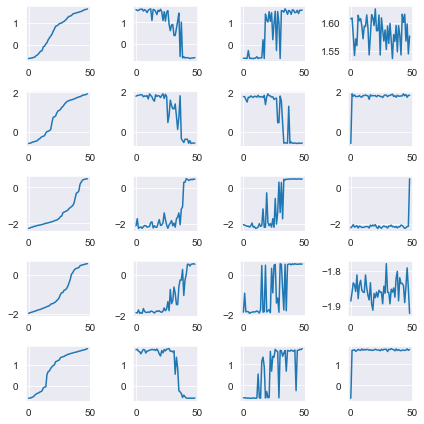

In [23]:
fig, axes = plt.subplots(5, 4, figsize=(6, 6))

for i in range(5):
    for j in range(4):
        axes[i, j].plot(trimmed[i][j])
        
plt.tight_layout()

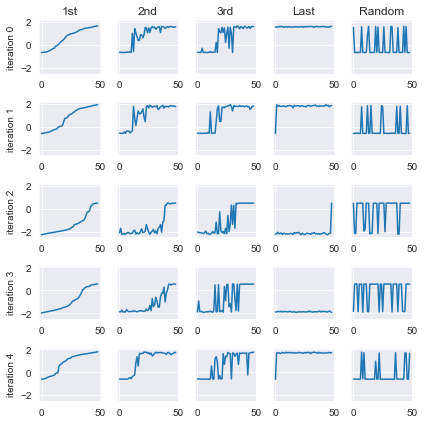

In [30]:
fig, axes = plt.subplots(5, 5, figsize=(6, 6), sharey=True)

labels = ['1st', '2nd', '3rd', 'Last', 'Random']

for i in range(5):
    for j in range(5):
        axes[i, j].plot(sloped[i][j])
        if j == 0:
            axes[i,j].set_ylabel(f'iteration {i}')
        if i == 0:
            axes[i, j].set_title(labels[j])
        
plt.tight_layout()

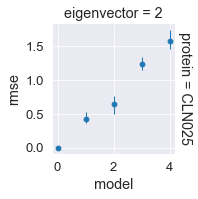

In [31]:
def func(x,y,lb,ub, **kwargs):
    data = kwargs.pop("data")
    plt.gca().errorbar(data[x], data[y], yerr=(data[lb], data[ub]), lw=0, elinewidth=1, marker='o')
    
    
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(data=comparisons, row='protein', col='eigenvector', margin_titles=True)
    g.map_dataframe(func, 'model', 'rmse', 'rmse_lb_diff', 'rmse_ub_diff')
    sns.set_style('darkgrid')
#     plt.savefig('unnormalized_model_comparisions.pdf')

In [59]:
# with sns.plotting_context('paper', font_scale=1.25):
#     n_rows, n_cols = 6, 2
#     sharey=True
    
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)
        
#     ylabel = 'VAMP-2'
#     xlabel = 'Rank'
    
#     for i in range(n_rows):
#         for j in range(n_cols):
#             ax = axes[i, j]

#             prot_ix = i*n_cols + j
#             label = funcs.PROTEIN_LABELS[prot_ix]
#             tmp = vamp_df.loc[vamp_df.protein==label, :]
            
#             if sharey:
#                 if j == 0:
#                     ax.set_ylabel(ylabel)
#             else:
#                 ax.set_ylabel(ylabel)

#             if i == n_rows - 1:
#                 ax.set_xlabel(xlabel)
                
 
#             for code, cat in enumerate(tmp.feature.cat.categories):
#                 ix = tmp.feature == cat
#                 x = tmp.loc[ix, 'hp_rank']
#                 y = tmp.loc[ix, 'median']
#                 yerr = tmp.loc[ix, ['lb_err', 'ub_err']].values.T
#                 ax.errorbar(x, y, yerr, lw=0, marker='o', elinewidth=1, c=funcs.cols[code], ms=3, label=cat)
            
#             if label in proc_dict.keys():
#                 xlim = ax.get_xlim()
#                 ax.hlines(proc_dict[label], *xlim, color='k', label='Max. VAMP-2')
#                 ax.set_xlim(xlim)
            
#             if (i == 0) & (j == n_cols - 1):
#                 ax.legend(bbox_to_anchor=(1, 1))
            

            
#             ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.05, 0.1), 
#                         xycoords='axes fraction', ha='left', va='bottom', 
#                        bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
    
#     plt.tight_layout()
#     plt.savefig(funcs.FIG_DIR.joinpath(f'vamp_scores_ranked.pdf'), bbox_inches='tight')

,protein,eigenvector,model,rmse,rmse_lb,rmse_ub,rmse_lb_diff,rmse_ub_diff
0,1fme,2,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1fme,2,1,0.012807,0.002119,0.032463,0.010688,0.019656
2,1fme,2,2,0.012862,0.001910,0.028329,0.010952,0.015466
3,1fme,3,0,0.000000,0.000000,0.000000,0.000000,0.000000
4,1fme,3,1,0.008421,0.001531,0.017945,0.006890,0.009524
5,1fme,3,2,0.008380,0.001673,0.016860,0.006707,0.008480
6,1fme,4,0,0.000000,0.000000,0.000000,0.000000,0.000000
7,1fme,4,1,0.005902,0.000336,0.014957,0.005565,0.009056
8,1fme,4,2,0.006783,0.000490,0.015573,0.006293,0.008790
9,2f4k,2,0,0.000000,0.000000,0.000000,0.000000,0.000000
